<img src="../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Brain Observatory - Visual Behavior </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Monday, August 23, 2021</h3> 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Visual Behavior Exercises Overview </h2>
    
<p> This notebook contains exercises covering several topics including behavior performance, single cell physiology and across session analysis.
  
<p> The exercises can be done in sequential order, or you can skip around to the exercises that interest you most. 
    
<p> If you get stuck, please ask a TA for help, look it up on stackoverflow, or check the solutions notebook. 
    We dont expect you to know everything already - the goal is to learn, and learning requires making mistakes and asking questions. 

<h3>Outline </h3>

<p><b>Behavior Exercises</b>
<ul><li>Exercise 1.1: Plot the distribution of reaction times for go trials from one session
    <li>Exercise 1.2: Plot reward rate over time during a session
<li>Exercise 1.3: Compute and plot hit rate over time during a session
<li>Exercise 1.4: Plot the average hit rate for each image
<li>Exercise 1.5: Plot the response probability for all image transitions
</ul>
<p><b>Single Cell Physiology Exercises</b> - this section requires stimulus_response_df as well as other mindscope_utilities functions
<ul><li>Exercise 2.1: Plot activity across stimulus repetitions using the flash response dataframe
<li>Exercise 2.2: Correlate neural activity with running speed on a trial by trial basis
<li>Exercise 2.3: Plot the trial averaged response across images for one cell using the stimulus response dataframe
<li>Exercise 2.4: Create a heatmap of all cells' averaged responses following an image change. 


</ul>
<p><b>Across Session Physiology Exercises</b>
<ul><li>Exercise 3.1: Follow along to learn some useful pandas tricks for multi session data comparison
<li>Exercise 3.2: Compare the activity of matched cells across sessions
<li>Exercise 3.3: Merge all the experiments from a single container and plot the mean response for different image sets
<li>Exercise 3.4: Plot the trial averaged response for passive vs. active sessions from one container
</ul>
</div>

In [1]:
# you will need these libraries for computation & data manipulation
import os
import numpy as np
import pandas as pd

# matplotlib is a standard python visualization package
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn is another library for statistical data visualization
# seaborn style & context settings make plots pretty & legible automatically
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white');
sns.set_palette('deep');

In [2]:
# Import allensdk modules for loading and interacting with the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache



In [3]:
# This cell will find the appropriate path to the data based on your platform.
# You may need to edit the strings in this cell based on your configuration.

import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS
    data_root = "/Volumes/Brain2019/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of the hard drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then linux (default here is for Ubuntu - insert your username; your distribution may differ)
    data_root = "/media/$USERNAME/Brain2019"
    
cache_path = os.path.join(data_root, 'dynamic-brain-workshop/visual_behavior/2021')

In [4]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
#cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)
cache = VisualBehaviorOphysProjectCache.from_lims()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Pick an ophys experiment based on its <code>cre_line</code>, <code>imaging_depth</code>, <code>session_number</code> and with no <code>prior_exposure_to_session_type</code></b> (aka not a retake of a session)
    
<p>1) Filter the experiments table according to your metadata of interest and get the <code>ophys_experiment_id</code> for a session of your choosing. 
    
<p>Hint: use pandas Boolean indexing to filter by multiple column values.
    
 __[Documentation for Boolean indexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html)__


In [7]:
experiments_df = cache.get_ophys_experiment_table()

In [8]:
experiments_df.head()

,equipment_name,donor_id,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,foraging_id,session_type,...,ophys_container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,isi_experiment_id,imaging_depth,targeted_structure,published_at,date_of_acquisition
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
958527471,MESO.1,850862423,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,0210d6f7-93f7-4bc1-a622-5c22b1daa11c,OPHYS_3_images_A,...,1018028345,VisualBehaviorMultiscope,published,passed,20190924_457841_3imagesA,858992726,225,VISp,2021-03-25,2019-09-24 16:00:00
958527477,MESO.1,850862423,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,0210d6f7-93f7-4bc1-a622-5c22b1daa11c,OPHYS_3_images_A,...,1018028348,VisualBehaviorMultiscope,failed,failed,20190924_457841_3imagesA,858992726,300,VISp,NaT,2019-09-24 16:00:00
958527474,MESO.1,850862423,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,0210d6f7-93f7-4bc1-a622-5c22b1daa11c,OPHYS_3_images_A,...,1018028339,VisualBehaviorMultiscope,published,passed,20190924_457841_3imagesA,858992726,75,VISp,2021-03-25,2019-09-24 16:00:00
958527485,MESO.1,850862423,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,0210d6f7-93f7-4bc1-a622-5c22b1daa11c,OPHYS_3_images_A,...,1018028351,VisualBehaviorMultiscope,published,passed,20190924_457841_3imagesA,858992726,75,VISl,2021-03-25,2019-09-24 16:00:00
958527479,MESO.1,850862423,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,0210d6f7-93f7-4bc1-a622-5c22b1daa11c,OPHYS_3_images_A,...,1018028354,VisualBehaviorMultiscope,published,passed,20190924_457841_3imagesA,858992726,150,VISl,2021-03-25,2019-09-24 16:00:00


In [9]:
selected_experiments = experiments_df[(experiments_df.cre_line == 'Vip-IRES-Cre') &
                                   (experiments_df.imaging_depth == 175) & 
                                   (experiments_df.session_number == 4) &
                                   (experiments_df.prior_exposures_to_session_type == 0)]
selected_experiments.head()

,equipment_name,donor_id,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,foraging_id,session_type,...,ophys_container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,isi_experiment_id,imaging_depth,targeted_structure,published_at,date_of_acquisition
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
795953296,CAM2P.4,744911447,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,152.0,7b725c5e-e68b-4bf5-a6d2-2a9879ca729b,OPHYS_4_images_B,...,791352433,VisualBehavior,published,passed,20181214_412036_4imagesB,754116317,175,VISp,2021-03-25,2018-12-14 20:17:05.000000
830093338,CAM2P.4,791756316,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,429952,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],M,138.0,45b8639c-e529-41ec-8963-c78fac2dc6c5,OPHYS_4_images_B,...,825183217,VisualBehavior,published,passed,20190227_429952_4imagesB,802841369,175,VISp,2021-03-25,2019-02-27 16:09:43.000000
935426822,CAM2P.3,879064131,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,467951,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],M,135.0,db87c2a1-ea6d-4356-b044-6decb73be2d4,OPHYS_4_images_A,...,928325203,VisualBehaviorTask1B,published,failed,20190829_467951_4imagesA,888237949,175,VISp,2021-03-25,2019-08-29 17:37:55.000000
1010556655,MESO.1,990779712,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,499478,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,142.0,d4e7b1c5-969e-45b8-a8df-fb5646b29ab8,OPHYS_4_images_H,...,1018027809,VisualBehaviorMultiscope4areasx2d,published,passed,20200226_499478_4imagesH,994736136,175,VISal,2021-08-12,2020-02-26 08:55:03.479109
968651977,CAM2P.4,880255009,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,467953,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],M,183.0,9a74ba11-c701-48cc-a7fb-b179cec788b5,OPHYS_4_images_A,...,957570596,VisualBehaviorTask1B,published,passed,20191016_467953_4imagesA,888943558,175,VISp,2021-03-25,2019-10-16 15:28:20.000000


In [10]:
experiment_id = selected_experiments.index.values[0]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>2) Load the experiment object for your experiment.

</div>

In [11]:
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior Exercises</h2>

<p> This set of exercises explores precomputed behavior metrics, using the 'trials' dataframe. The 'trials' dataframe is organized around the times of stimulus identity changes (go trials) and sham change times (catch trials). It contains data and metadata for each trial, including lick times, reward times, and image identity. <b>Note:</b> the behavioral trials are not the same as stimulus trials. One behavioral trial contains multiple stimulus presentations (or trials). 
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">.
<p><b>Exercise 1.1: Plot the distribution of reaction times for go trials from one session</b>

<p> 1) Get the <code>trials</code> dataframe from the session object. 
  
</div>

In [12]:
# copy trials df
trials_df = ophys_experiment.trials.copy()
# display columns of trials df
trials_df.tail()

C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'behavior_monitoring', 'eye_tracking'}. Consider updating the sync file line labels.
  self._check_line_labels()


,lick_times,reward_time,reward_volume,hit,false_alarm,miss,stimulus_change,aborted,go,catch,...,correct_reject,start_time,stop_time,trial_length,response_time,change_frame,change_time,response_latency,initial_image_name,change_image_name
trials_id,,,,,,,,,,,,,,,,,,,,,
687,[],NaN,0.0,False,False,True,True,False,True,False,...,False,3866.36363,3874.37003,8.00640,NaN,231597.0,3870.137861,inf,im054,im045
688,[],NaN,0.0,False,False,True,True,False,True,False,...,False,3874.62042,3881.87591,7.25549,NaN,232047.0,3877.643651,inf,im045,im031
689,[],NaN,0.0,False,False,True,True,False,True,False,...,False,3882.12612,3890.88339,8.75727,NaN,232587.0,3886.650991,inf,im031,im035
690,[],NaN,0.0,False,False,False,False,False,False,True,...,True,3891.13345,3899.13998,8.00653,NaN,233082.0,3894.907701,inf,im035,im035
691,[],NaN,0.0,False,False,True,True,False,True,False,...,False,3899.39020,3911.90046,12.51026,NaN,233847.0,3907.668131,inf,im035,im106


In [13]:
trials_df.keys()

Index(['lick_times', 'reward_time', 'reward_volume', 'hit', 'false_alarm',
       'miss', 'stimulus_change', 'aborted', 'go', 'catch', 'auto_rewarded',
       'correct_reject', 'start_time', 'stop_time', 'trial_length',
       'response_time', 'change_frame', 'change_time', 'response_latency',
       'initial_image_name', 'change_image_name'],
      dtype='object')

`trials_df` contains many columns:
* `lick_times` -  if the animal licked during a trial, timestamps of licks in seconds
* `reward_time` - if the animal was rewarded during a trial, timestamps of reward in seconds
* `reward_volumn` - volume of water disposed if rewarded, in ml
* `hit` - if it was a hit trial, meaning a go trial that animal got correctly
* `false_alarm` - if it was a false alarm trial, meaning a no-go trial when animal licked
* `miss` - if it was a miss trial, a go trial but animal did not lick
* `stimulus_change` if the stimulus changed on this trial
* `aborted` - if the animal licked too quickly when the trials started, the trial was aborted
* `go` - if it was a go trials, True or False
* `catch` - if it was a catch trial, True or False (catch trial is a trial that would have been a go, but the image did not change
* `auto_rewarded` - if the trial was autorewarded; the first 5 go trials in the session are autorewarded to prime the animals for the task
* `correct_reject` - if the trial was a catch trial and the animal did not lick
* `start_time`
* `stop_time`
* `trial_length`
* `response_time`
* `change_frame`
* `change_time`
* `response_latency`
* `initial_image_name`
* `change_image_name`


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">.
    <p> 2) Filter the trials dataframe to get <code>go</code> trials only. 
</div>

In [14]:
# display values in response latency column for go trials
trials_df[trials_df['go']==True].response_latency

trials_id
3           inf
5      0.779499
6           inf
8      0.612649
10     1.029649
         ...   
685         inf
687         inf
688         inf
689         inf
691         inf
Name: response_latency, Length: 214, dtype: float64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <b>Note:</b> <code>go</code> trials during which the animals did not respond have <code>inf</code> as a reponse latency value. This can be an inssue for plotting, because many functions expect finate values. We can replace <code>inf</code> with <code>NaN</code>.
</div>    

In [15]:
# replace 'inf' with 'NaN'
trials_df['response_latency'].replace(to_replace=np.inf, value=np.nan, inplace=True)

In [16]:
trials_df[trials_df['go']==True]['response_latency']

trials_id
3           NaN
5      0.779499
6           NaN
8      0.612649
10     1.029649
         ...   
685         NaN
687         NaN
688         NaN
689         NaN
691         NaN
Name: response_latency, Length: 214, dtype: float64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 3) Use the values of the <code>response_latency</code> column to plot a histogram of reaction times. 
    
<p> <code>response_latency</code> is defined as the first lick time, in seconds, relative to the change time. 
</div>

C:\Users\iryna.yavorska\Anaconda3\envs\neuromatch\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\iryna.yavorska\Anaconda3\envs\neuromatch\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'time after change (sec)')

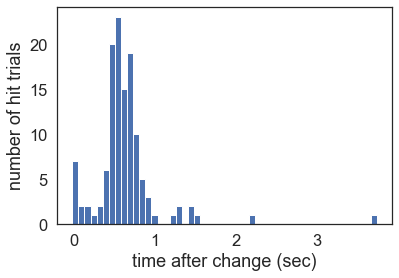

In [18]:
# plot histogram of response latencies
plt.hist(trials_df[trials_df['go']==True].response_latency.values, bins=50);
plt.ylabel('number of hit trials')
plt.xlabel('time after change (sec)')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.2: Plot reward volumn over time during a session</b>

<p> 1) Use <code>calculate_reward_rate</code> in AllenSDK's <code>trial_processing</code> module to create a column <code>reward_rate</code> and <code>change_time</code> columns of the trials dataframe to plot reward rate over time. 
   
<p> Was the mouse actively performing the task and earning rewards during the entire session? 
    
</div>

In [19]:
from allensdk.brain_observatory.behavior.trials_processing import calculate_reward_rate

In [20]:
trials_df['reward_rate'] = calculate_reward_rate(trials_df['response_latency'].values, 
                                              trials_df['start_time'], window = 1.5)

In [21]:
# remove behavioral trials that were aborted due to animal's premature licking
trials_df_sel = trials_df[trials_df['aborted']==False]

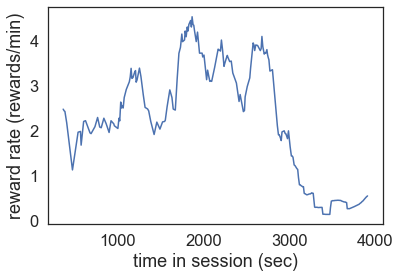

In [22]:
plt.plot(trials_df_sel['change_time'], trials_df_sel['reward_rate'])
plt.xlabel('time in session (sec)');
plt.ylabel('reward rate (rewards/min)');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.3: Compute and plot hit rate over time during a session</b>

<p> 1) Filter the trials dataframe to get the <code>hit</code> column for <code>go</code> trials only. Assign this to a new variable called <code>go_responses</code> for further analysis. <b>Note:</b> Make sure that you get <code>go_responses</code> as a pandas series, without calling <code>.values</code>, so that the next step will work properly. 
    
<p> The <code>hit</code> column of the trials dataframe contains <i>True</i> for all trials where there was a licking response within the 750ms reward window and <i>False</i> where there was not. 

<p> 2) Apply the pandas <code>rolling()</code> method to <code>go_responses</code> followed by <code>.mean()</code> to take a rolling mean across go trials. Set <code>window = 25, center = True</code> in the call to <code>rolling()</code> for a centered window over 25 trials. Set the output of this step to a variable called <code>rolling_hit_rate</code>. 

 __[Documentation for pandas.rolling()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html)__
       
</div>

In [23]:
# total number of hits (True) and misses (False) in the go trials
trials_df[trials_df['go']==True]['hit'].value_counts()

False    119
True      95
Name: hit, dtype: int64

It's not uncommon for sessions to have more misses than hits. Not all mice do the task well during multiple days. It's also very common for mice to do the task well at the beginning of a session but not towards the end of a session. This trend is likely related to lack of motivation after receiving sufficient reward.

In [24]:
go_responses = trials_df[trials_df['go']==True]['hit']
rolling_hit_rate = go_responses.rolling(window=25, center=True).mean()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> 3) Plot the <code>rolling_hit_rate</code>. Label your axes.
       
</div>

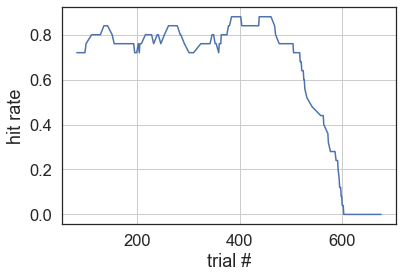

In [25]:
plt.plot(rolling_hit_rate)
plt.xlabel('trial #')
plt.ylabel('hit rate');
plt.grid()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.4: Plot the average hit rate for each image</b>

<p>1) Loop through the 8 images in this session and quantify the fraction of go trials where there was a correct response for each image to get the mean hit rate across the session. <b>Hint:</b> Use <code>ophys_experiment.trials.change_image_name.unique()</code> to get the image names.
    
<p>2) Plot the average hit rate for each image, with image names along the x-axis. Using <code>ophys_experiment.stimulus_template</code>, plot stimuli that were presented during this session.
    
<p> <b>Bonus:</b> Sort hit rate values in ascending order and apply the same sorting to the image names along the x-axis. Hint: Useful functions include np.sort() and np.argsort()

    
</div>

In [26]:
# get the hit rate for each image
hit_rates = []
images = trials_df['change_image_name'].unique()
for image in images:
    image_change_trials = trials_df[(trials_df['change_image_name'] == image) & 
                                 (trials_df['go'] == True)]
    hit_rates.append(np.sum(image_change_trials['hit'])/len(image_change_trials))

In [27]:
# sort the hit rates in ascending order and sort the image labels in the same order
hit_rates_sorted = np.sort(hit_rates)
sorted_order = np.argsort(hit_rates)
images_sorted = images[sorted_order]

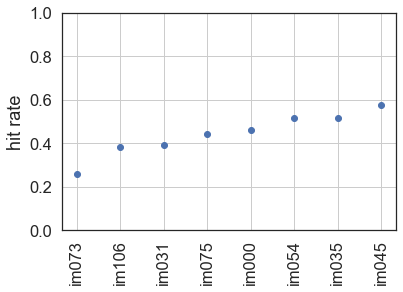

In [31]:
# plot hit rate by image with image names on the x-axis
fig, ax = plt.subplots()
plt.plot(hit_rates_sorted, 'o')
ax.set_xticks(np.arange(0,len(images_sorted),1));
ax.set_xticklabels(images_sorted, rotation=90);
ax.set_ylabel('hit rate');
ax.set_ylim(0,1);
ax.grid()

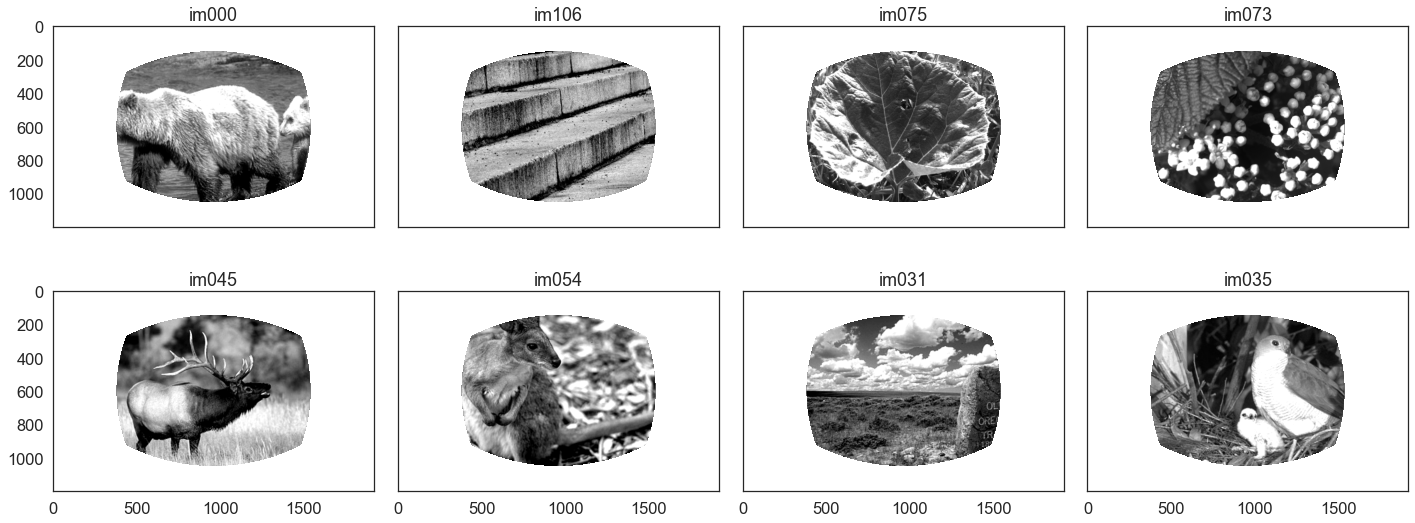

In [32]:
fig, ax = plt.subplots(2,4,figsize = (20,8), sharex = True, sharey=True)
for ii,image_name in enumerate(ophys_experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(ophys_experiment.stimulus_templates.loc[image_name]['unwarped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.5: Plot the response probability for all image transitions</b>

<p> The task cycles through 8 different images, resulting in 64 possible image transitions. Some image transitions might be easier for the mouse to detect than others. 

<p> 1) Use pandas <code>pivot_table</code> on the trials table to aggregate and average the <code>response_binary</code> values by <code>initial_image_name</code> and <code>change_image_name</code>. This will create a matrix of response probability for all image transitions. 
    
 __[Documentation for pandas.pivot_table()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html)__ 
 
</div>

In [33]:
# use pivot table to make a matrix of respones probability
response_matrix = pd.pivot_table(trials_df,  
                                 values='hit', 
                                 index='initial_image_name',
                                 columns='change_image_name')
response_matrix

change_image_name,im000,im031,im035,im045,im054,im073,im075,im106
initial_image_name,,,,,,,,
im000,0.000000,0.25,0.50,0.500000,0.500000,0.00,0.666667,0.000000
im031,0.500000,0.00,0.25,0.500000,0.500000,0.25,0.250000,0.250000
im035,0.500000,0.50,0.00,0.666667,0.750000,0.25,0.500000,0.500000
im045,0.666667,0.00,0.50,0.000000,0.500000,0.00,0.500000,0.500000
im054,0.666667,0.50,0.25,0.500000,0.000000,0.25,0.500000,0.500000
im073,0.250000,0.50,0.50,0.500000,0.250000,0.00,0.250000,0.666667
im075,0.250000,0.50,0.75,0.500000,0.500000,0.50,0.000000,0.333333
im106,0.500000,0.50,1.00,1.000000,0.666667,0.50,0.500000,0.000000


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 2) Plot the hit transition matrix as a heatmap. Try using seaborn's heatmap function.

 __[Documentation for seaborn.heatmap()](https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap)__ 
    

<p> Did the mouse respond similarly for image changes compared to the same image repeated on catch trials? Are some image transitions more detectable than others? 

</div>

<AxesSubplot:xlabel='change_image_name', ylabel='initial_image_name'>

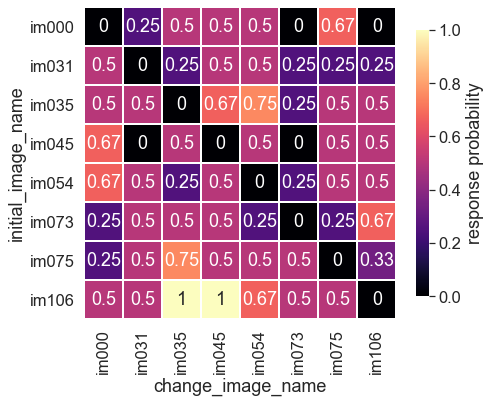

In [34]:
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(response_matrix, vmin=0, vmax=1, cmap='magma',
            square=True, annot=True, linewidths=0.01, cbar_kws={"shrink": 0.7, "label": 'response probability'}, ax=ax)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Bonus:</b> Plot response probability across image transitions for engaged trials only


<p> Filter out trials where the mouse wasn't reliably performing the task using the value of the <code>reward_rate</code> column, with a threshold of 2 rewards per minute to distinguish engaged from disengaged periods, then plot the transition heatmap again. 

<p> Does varying engagement influence how we should analyze neural activity?

</div>

<AxesSubplot:xlabel='change_image_name', ylabel='initial_image_name'>

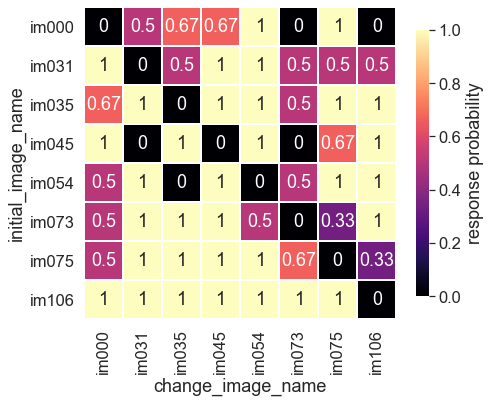

In [35]:
response_matrix = pd.pivot_table(trials_df[trials_df['reward_rate']>2],  
                                 values='hit', 
                                 index='initial_image_name',
                                 columns='change_image_name')

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(response_matrix, vmin=0, vmax=1, cmap='magma',
            square=True, annot=True, linewidths=0.01,
            cbar_kws={"shrink": 0.7, "label": 'response probability'}, ax=ax)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Single Cell Physiology Exercises</h2>
    
<p> These exercises explore neural activity aligned to stimulus trials. They make use of the <code>get_stimulus_response_df</code> function and <code>stimulus_presentations</code> dataframe, as well as additional help functions in mindscope utilities that can add additional columns to stimulus_presentations_df with information about licks, rewards, mean pupil area or running speed. 

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;"
<p><b>Info about stimulus_presentations and stimulus_response dataframes</b>
    
<p> The <code>stimulus_presentations_df</code> contains metadata about each stimulus presentation in a given session. Additional steps are needed to add information about trials and animal behavior.
    
<p> The <code>stimulus_response_df</code> contains the response of each cell to each individual stimulus presentation during the session. 
    
<p> Both dataframes have a column called <code>trace</code> that contains a segment of each cell's fluorescence trace over a window of time. The duration of the window over which the <code>trace</code> was extracted can be specified in <code>get_stimulus_response</code> using <code>time_window</code> input variable. 
    
<p> If <code>compute_means</code> is True (default) in <code>get_stimulus_response</code>, you will have a column <code>mean_response</code> in the dataframe that contains each cell's response averaged over [0 time_window[1]] and <code>baseline_response</code> with pre stimulus activity mean.

</div>

In [36]:
import mindscope_utilities.visual_behavior_ophys as ophys
%load_ext autoreload
%autoreload 2

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.1: Plot activity across stimulus repetitions using the stimulus response dataframe and stimulus_presentations</b>

<p> 1) Assign the output of <code>ophys.get_stimulus_response_df()</code> for image changes only to a variable called <code>stimulus_response_df</code>. Make sure to check out documentation for this function to learn how to use it. You can call <code>help(function_name)</code> or <code>function_name()?</code> to print documentation. 

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> Examine the <code>ophys.get_stimulus_response_df</code> to get a better understanding of the input variables. 

</div>

In [37]:
ophys.get_stimulus_response_df?

In [39]:
# get stimulus response dataframe, for 'dff' traces and only image changes
experiment_id = selected_experiments.index.values[0]
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment, 
                                                     time_window = [-1, 1.5],
                                                     data_type = 'dff',
                                                     event_type = 'changes')

C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'behavior_monitoring', 'eye_tracking'}. Consider updating the sync file line labels.
  self._check_line_labels()
C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'behavior_monitoring', 'eye_tracking'}. Consider updating the sync file line labels.
  self._check_line_labels()
100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.23it/s]


In [40]:
stimulus_response_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response
0,28,1086490397,"[-0.10610490292310715, -0.024462345094067597, ...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.097327,-0.020554
1,28,1086490441,"[1.2530322074890137, 1.1605233202650276, 1.232...","[-1.0, -0.9676781056230949, -0.935356211246189...",1.612638,1.314280
2,28,1086490480,"[-0.11520564556121826, -0.08244695689334353, 0...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.073871,-0.070798
3,28,1086490510,"[0.294612854719162, 0.42723664343041434, 0.426...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.993763,0.058067
4,28,1086490597,"[-0.06230897456407547, 0.02595783892605319, -0...","[-1.0, -0.9676781056230949, -0.935356211246189...",-0.008218,0.009103


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 2) Assign ophys_experiment.stimulus_presentations to a variable called <code>stimulus_presentations_df</code>. Use .copy() to make a copy of the dataframe in order to avoid accidently editing the original.

</div>

In [41]:
# get stimulus_presentations_df
stimulus_presentations_df = ophys_experiment.stimulus_presentations.copy()
stimulus_presentations_df.head()

,duration,end_frame,image_index,image_name,image_set,index,is_change,omitted,start_frame,start_time,stop_time
stimulus_presentations_id,,,,,,,,,,,
0,0.25021,18000.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17985,306.90981,307.16002
1,0.25018,18045.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,1,False,False,18030,307.66042,307.91060
2,0.25022,18090.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,2,False,False,18075,308.41101,308.66123
3,0.25012,18135.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,3,False,False,18120,309.16175,309.41187
4,0.25024,18180.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,4,False,False,18165,309.91222,310.16246


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> 3) Merge <code>stimulus_presentations_df</code> onto <code>stimulus_response_df</code> using <code>stimulus_presentations_id</code> column as a key.  Pick a cell and get all change trials for that cell by filtering your new <code>stimulus_response_df</code> by both the <code>cell_specimen_id</code> column and the <code>is_change</code> column.
</div>

In [42]:
# merge stimulus response df with stimulus presentations to a new df
stimulus_response_df = stimulus_response_df.join(stimulus_presentations_df, on='stimulus_presentations_id')

stimulus_response_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,duration,end_frame,image_index,image_name,image_set,index,is_change,omitted,start_frame,start_time,stop_time
0,28,1086490397,"[-0.10610490292310715, -0.024462345094067597, ...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.097327,-0.020554,0.25026,19260.0,3,im073,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,28,True,False,19245,327.92694,328.1772
1,28,1086490441,"[1.2530322074890137, 1.1605233202650276, 1.232...","[-1.0, -0.9676781056230949, -0.935356211246189...",1.612638,1.314280,0.25026,19260.0,3,im073,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,28,True,False,19245,327.92694,328.1772
2,28,1086490480,"[-0.11520564556121826, -0.08244695689334353, 0...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.073871,-0.070798,0.25026,19260.0,3,im073,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,28,True,False,19245,327.92694,328.1772
3,28,1086490510,"[0.294612854719162, 0.42723664343041434, 0.426...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.993763,0.058067,0.25026,19260.0,3,im073,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,28,True,False,19245,327.92694,328.1772
4,28,1086490597,"[-0.06230897456407547, 0.02595783892605319, -0...","[-1.0, -0.9676781056230949, -0.935356211246189...",-0.008218,0.009103,0.25026,19260.0,3,im073,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,28,True,False,19245,327.92694,328.1772


In [44]:
# get change stimulus trials for one cell only
cell_specimen_ids = stimulus_response_df.cell_specimen_id.unique()
cell_specimen_id = cell_specimen_ids[0]

stimulus_response_df_sel = stimulus_response_df[stimulus_response_df['cell_specimen_id']==cell_specimen_id]
stimulus_response_df_sel.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,duration,end_frame,image_index,image_name,image_set,index,is_change,omitted,start_frame,start_time,stop_time
0,28,1086490397,"[-0.10610490292310715, -0.024462345094067597, ...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.097327,-0.020554,0.25026,19260.0,3,im073,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,28,True,False,19245,327.92694,328.17720
33,41,1086490397,"[0.6293858885765076, 0.45818522909995896, 0.58...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.346553,0.537860,0.25020,19845.0,5,im054,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,41,True,False,19830,337.68490,337.93510
66,51,1086490397,"[0.19601398706436157, 0.2025626609180043, 0.27...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.162377,0.206973,0.25018,20295.0,3,im073,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,51,True,False,20280,345.19102,345.44120
99,68,1086490397,"[0.37653717398643494, 0.3406723946202891, 0.39...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.255973,0.227097,0.25021,21060.0,7,im035,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,68,True,False,21045,357.95142,358.20163
132,85,1086490397,"[0.6566617488861084, 0.8565127050266041, 0.620...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.415265,0.822006,0.25020,21825.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,85,True,False,21810,370.71183,370.96203


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> Get the values of the <code>trace</code> column from your selected dataframe. Loop through these values and plot the traces for all change trials. Set color='gray. 
    
<b>Bonus:</b> Plot with time relative to the stimulus onset, in seconds, on the x-axis. Hint: Use the <code>trace_timestamps</code> column to get time relative to stimulus onset for one stimulus presentation.
    
<p> 4) Take the mean of the <code>trace</code> values and plot the average response on the same figure as the individual trials, this time setting color='b'.

Does this cell have a reliable response to image changes? 

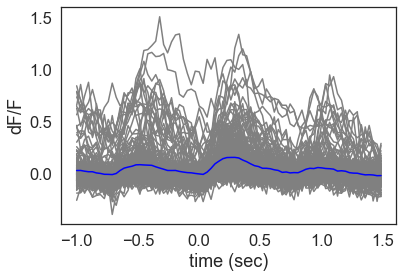

In [45]:
# plot for one cell
time_seconds = stimulus_response_df_sel.iloc[0]['trace_timestamps']

mean_trace = stimulus_response_df_sel['trace'].mean()

# loop through all trials and plot 
for trace in stimulus_response_df_sel['trace'].values: 
    plt.plot(time_seconds, trace, color='gray')
plt.xlabel('time (sec)')
plt.ylabel('dF/F')

# plot trace average
plt.plot(time_seconds, mean_trace, color='b');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">   

<p> 5) Create this plot for multiple cells. How do different cells respond image changes?
    
<b>Bonus:</b> Plot multiple cells in one figure on different axes. Use <code>fig, ax = plt.subplots()</code> followed by <code>ax = ax.ravel()</code> to create iterable axes. 

 __[Documentation for matplotlib.pyplot.subplots()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots.html)__ 
    
 __[Why use fig, ax = plt.subplots() ? ](https://stackoverflow.com/questions/34162443/why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python )__ 

</div>

In [ ]:
# plot for 15 cells
cell_specimen_ids = stimulus_response_df['cell_specimen_id'].unique()
fig, ax = plt.subplots(3,5, figsize=(15,8))
ax = ax.ravel()
if len(cell_specimen_ids) >=15:
    max_subplots = 15
else:
    max_subplots = len(cell_specimen_ids)
    
for i,cell_specimen_id in enumerate(cell_specimen_ids[:max_subplots]): 
    stimulus_response_df_sel = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) &
                                             (stimulus_response_df['is_change']==True)] # this line is redundant if you set event_type='changes'
    time_seconds = stimulus_response_df_sel.iloc[0]['trace_timestamps']
    mean_trace = np.mean(stimulus_response_df_sel['trace'].values)
    
    for trace in stimulus_response_df_sel['trace'].values: 
        ax[i].plot(time_seconds, trace, color='gray')
    ax[i].set_xlabel('time (sec)')
    ax[i].set_ylabel('dF/F')
    
    ax[i].plot(time_seconds, mean_trace, color='b')
fig.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.2: Correlate neural activity with running speed on a trial by trial basis</b>

<p> Trial to trial variability could arise from differences in animal behavior. One possibility is modulation by running speed. 

<p> 1) Pick a cell and select all presentations of one image. 
    
<p> 2) Create a scatterplot of running speed vs neural response magnitude using the <code>mean_response</code> in <code>stimulus_response_df</code> and <code>mean_running_speed</code> columns that can be added to <code>stimulus_presentations</code> dataframe using <code>add_mean_running_speed_to_stimulus_presentations</code>. 

<p> The <code>mean_running_speed</code> is the average of the running_speed trace during the 250ms stimulus presentation for each image presentation. 
    
</div>

In [59]:
# get stimulus response dataframe
experiment_id = selected_experiments.index.values[0]
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)

# get stimulus_presentations
stimulus_presentations_df = ophys_experiment.stimulus_presentations.copy()


C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'behavior_monitoring', 'eye_tracking'}. Consider updating the sync file line labels.
  self._check_line_labels()
C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'behavior_monitoring', 'eye_tracking'}. Consider updating the sync file line labels.
  self._check_line_labels()
100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [01:39<00:00,  3.02s/it]


In [51]:
stimulus_response_df.loc[0]['trace_timestamps'].min()

-1.0

In [52]:
time_window = [stimulus_response_df.loc[0]['trace_timestamps'].min(), 
               stimulus_response_df.loc[0]['trace_timestamps'].max()]

In [54]:
# add mean running speed
running_speed = ophys_experiment.running_speed.copy()
stimulus_presentations_df = ophys.add_mean_running_speed_to_stimulus_presentations(stimulus_presentations_df,
                                                                                  running_speed = running_speed,
                                                                                  time_window = time_window)

In [55]:
stimulus_presentations_df.head()

,duration,end_frame,image_index,image_name,image_set,index,is_change,omitted,start_frame,start_time,stop_time,mean_running_speed
stimulus_presentations_id,,,,,,,,,,,,
0,0.25021,18000.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17985,306.90981,307.16002,22.302780
1,0.25018,18045.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,1,False,False,18030,307.66042,307.91060,16.839448
2,0.25022,18090.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,2,False,False,18075,308.41101,308.66123,13.211060
3,0.25012,18135.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,3,False,False,18120,309.16175,309.41187,17.257910
4,0.25024,18180.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,4,False,False,18165,309.91222,310.16246,17.762481


In [57]:
# get stimulus response df for image presentations only (excluding omissions)
time_window = [-1, 1.5]
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment, 
                                                     time_window = time_window,
                                                     data_type = 'dff',
                                                     event_type = 'images')

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [01:35<00:00,  2.91s/it]


In [58]:
stimulus_response_df = stimulus_response_df.join(stimulus_presentations_df, 
                                                on='stimulus_presentations_id')

In [59]:
stimulus_response_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,duration,end_frame,image_index,image_name,image_set,index,is_change,omitted,start_frame,start_time,stop_time,mean_running_speed
0,0,1086490397,"[-0.08918015658855438, 0.03434509787095638, 0....","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.020738,-0.028556,0.25021,18000.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17985,306.90981,307.16002,22.30278
1,0,1086490441,"[0.06538864225149155, -0.11673464244326356, 0....","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",-0.005531,-0.010539,0.25021,18000.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17985,306.90981,307.16002,22.30278
2,0,1086490480,"[-0.08951027691364288, 0.04373886368737116, -0...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",-0.012640,-0.039058,0.25021,18000.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17985,306.90981,307.16002,22.30278
3,0,1086490510,"[0.018823765218257904, 0.00320601547231697, -0...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.283500,-0.054982,0.25021,18000.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17985,306.90981,307.16002,22.30278
4,0,1086490597,"[0.10280489921569824, 0.04192127787972573, -0....","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.017329,0.011642,0.25021,18000.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17985,306.90981,307.16002,22.30278


In [61]:
cell_specimen_ids = stimulus_response_df['cell_specimen_id'].unique()


In [66]:
# select one cell
cell_specimen_id = cell_specimen_ids[4]

# select response of the cell to one image type
stimulus_response_df_sel = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) & 
                                         (stimulus_response_df['image_index']==0)]
stimulus_response_df_sel.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,duration,end_frame,image_index,image_name,image_set,index,is_change,omitted,start_frame,start_time,stop_time,mean_running_speed
4,0,1086490597,"[0.10280489921569824, 0.04192127787972573, -0....","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.017329,0.011642,0.25021,18000.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17985,306.90981,307.16002,22.302780
37,1,1086490597,"[-0.07289396226406097, -0.14405558601704063, 0...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",-0.003335,-0.013574,0.25018,18045.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,1,False,False,18030,307.66042,307.91060,16.839448
70,2,1086490597,"[0.0669265165925026, -0.02763922292264785, -0....","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",-0.025184,0.013170,0.25022,18090.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,2,False,False,18075,308.41101,308.66123,13.211060
103,3,1086490597,"[-0.061010368168354034, -0.03738173310993105, ...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.023624,-0.023525,0.25012,18135.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,3,False,False,18120,309.16175,309.41187,17.257910
136,4,1086490597,"[-0.0020585244055837393, 0.12207145159049289, ...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",-0.018796,-0.020350,0.25024,18180.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,4,False,False,18165,309.91222,310.16246,17.762481


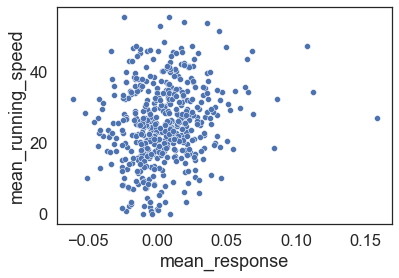

In [67]:
# plot scatter plot of mean response vs. running speed
fig, ax = plt.subplots()
ax = sns.scatterplot(data=stimulus_response_df_sel, x='mean_response', y='mean_running_speed', ax=ax)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 2) Compute the Pearson correlation between the image-trial-wise <code>mean_response</code> and <code>mean_running_speed</code> using <code>scipy.stats.pearsonr()</code>. Is there a correlation? 

</div>

In [68]:
# get pearson correlation 
import scipy.stats as st
r, p = st.pearsonr(stimulus_response_df_sel['mean_response'].values, stimulus_response_df_sel['mean_running_speed'].values)
print('r = ', np.round(r,3), 'p = ', np.round(p,3))

r =  0.192 p =  0.0


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> Bonus: Compute the running correlation for all cells in the session and plot a histogram of the values. 

</div>

In [71]:
# get pearson correlation values for all cells
r_values = []
for cell_specimen_id in cell_specimen_ids:
    tmp = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) & 
                                             (stimulus_response_df['image_index']==1)]
    r, p = st.pearsonr(tmp['mean_response'].values, tmp['mean_running_speed'].values)
    r_values.append(r)

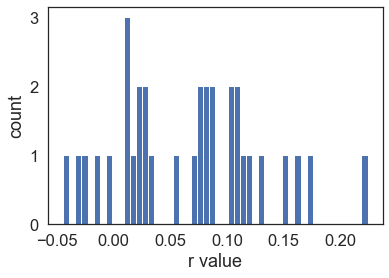

In [72]:
# plot distribution of pearson r values
plt.hist(r_values, bins=50);
plt.xlabel('r value');
plt.ylabel('count');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.3: Plot the trial averaged response across images for one cell using the trial response dataframe</b>
   
<p> 1) Using <code>get_stimulus_response_df</code> method, get averages of image responses from one ophys experiment.
    
<p> 2) Are there differences in mean responses for different images? 

<p> 3) What are the differences between the images? Plot stimuli from <code>ophys_experiment.stimulus_templates</code> that were presented during this session. </p>
</div>

In [74]:
# get trial_response_df
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment,
                                                     data_type = 'dff',
                                                     event_type = 'images',
                                                     time_window = [-1, 1.5])

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [01:37<00:00,  2.95s/it]


In [76]:
#append stimulus presentaiton information to response df
stimulus_presentations_df = ophys_experiment.stimulus_presentations.copy()

stimulus_response_df = stimulus_response_df.join(stimulus_presentations_df, 
                                                on='stimulus_presentations_id')

<AxesSubplot:xlabel='image_name', ylabel='mean_response'>

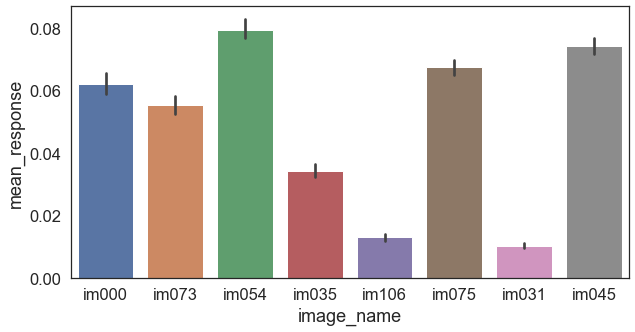

In [87]:
cell_specimen_ids = stimulus_response_df['cell_specimen_id'].unique()

fig, ax = plt.subplots(1,1, figsize =(10,5))
sns.barplot(data = stimulus_response_df, 
             y ='mean_response',
             x = 'image_name')

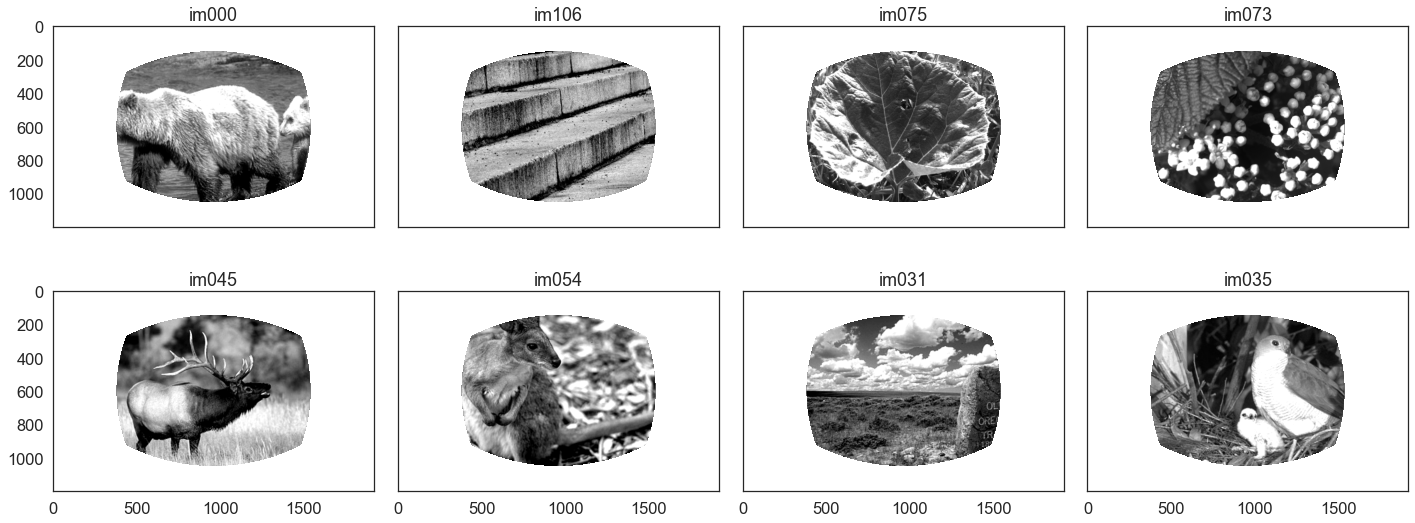

In [88]:
fig, ax = plt.subplots(2,4,figsize = (20,8), sharex = True, sharey=True)
for ii,image_name in enumerate(ophys_experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(ophys_experiment.stimulus_templates.loc[image_name]['unwarped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 3) Plot the average <code>dff_trace</code> across trials for the cell, image name, and trial type identified in the step above. Plot the x-axis in seconds relative to the <code>change_time</code>. 
    
Bonus: Show the the time of the change flash (from 0 to .25 seconds after the change time) using ax.vspan(). 
</div>

In [ ]:
# plot the trial averaged trace for the conditions identified above
cell_data = tr[(tr.cell_specimen_id==cell_specimen_id)&(tr.change_image_name==change_image_name)&(tr.go==go)]
mean_trace = cell_data.dff_trace.mean()
timestamps = tr.iloc[0].dff_trace_timestamps  - tr.iloc[0].change_time
plt.plot(timestamps, mean_trace, 'k')
plt.axvspan(0, 0.25 ,alpha=0.3,facecolor='blue')
plt.ylabel('mean dF/F');
plt.xlabel('time relative to change (sec)');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
 
<p> 4) Loop through the 8 images shown in this session and plot the average response for each image when it changes for this cell as a function of reward rate. Hint: use <code>add_reward_rate_to_stimulus_presentations_df</code> to add reward date to <code>stimulus_presentations_df</code>, then merge it onto <code>stimulus_response_df</code>
    
Bonus: Make the same plots but instead of plotting absolute mean responses, plot mean responses that are relative to the baseline response. Use <code>baseline_response</code> as your reference point. 
    
</div>

In [145]:
experiment_id = selected_experiments.index.values[0]
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment)

C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'behavior_monitoring', 'eye_tracking'}. Consider updating the sync file line labels.
  self._check_line_labels()
C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'behavior_monitoring', 'eye_tracking'}. Consider updating the sync file line labels.
  self._check_line_labels()
100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [01:38<00:00,  2.98s/it]


In [137]:
trials_df = ophys_experiment.trials.copy()
stimulus_presentations_df = ophys_experiment.stimulus_presentations.copy()

stimulus_presentations_df = ophys_add_reward_rate_to_stimulus_presentations_df(trials_df, stimulus_presentations_df)

In [146]:
stimulus_response_df = stimulus_response_df.join(stimulus_presentations_df, 
                                                on='stimulus_presentations_id')

Text(0.5, 1.0, 'response to change')

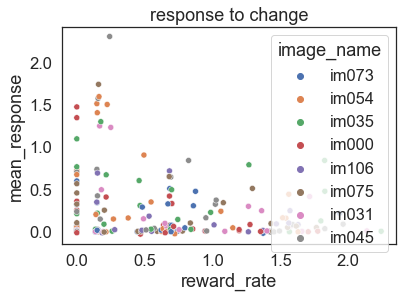

In [159]:


stim_reward_df = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) & 
                                 (stimulus_response_df['is_change']==True)]
ax = sns.scatterplot(data = stim_reward_df, 
                x = 'reward_rate', 
                y = 'mean_response',
                hue = 'image_name')
ax.set_title('response to change')

In [155]:
# make a new column with subtracted baseline response
stimulus_response_df['response_mean_rel'] = stimulus_response_df['mean_response'] - \
                                            stimulus_response_df['baseline_response']


Text(0.5, 1.0, 'response to change')

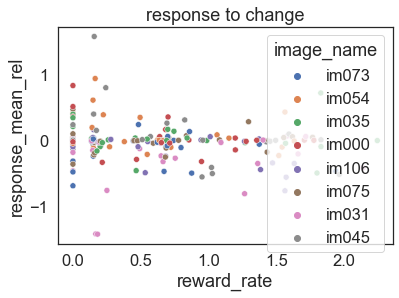

In [158]:
stim_reward_df = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) & 
                                 (stimulus_response_df['is_change']==True)]
ax = sns.scatterplot(data = stim_reward_df, 
                x = 'reward_rate', 
                y = 'response_mean_rel',
                hue = 'image_name')
ax.set_title('response to change')


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.4: Create a heatmap of all cells' trial averaged responses following an image change</b>

<p>From <code>stimulus_response_df</code>, use <code>mean()</code> method to take an average of response traces for each cell and add them to a new pandas dataframe with three columns: cell_specimen_id, mean_trace, trace_timestamps. Or create a response matrix of n_cells by n_timestamps.
       
<p>Sort responses using <code>np.argsort</code> before plotting to reveal any temporal structure in mean responses to changes
    
</div>

In [161]:
experiment_id = selected_experiments.index.values[0]
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment,
                                                     event_type = 'changes')

C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'behavior_monitoring', 'eye_tracking'}. Consider updating the sync file line labels.
  self._check_line_labels()
C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'behavior_monitoring', 'eye_tracking'}. Consider updating the sync file line labels.
  self._check_line_labels()
100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.35it/s]


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">


</div>

In [185]:
cell_specimen_ids = stimulus_response_df['cell_specimen_id'].unique()

mean_df = pd.DataFrame(columns = {'cell_specimen_id',
                                 'mean_trace',
                                 'trace_timestamps'})
timestamps = stimulus_response_df.iloc[0]['trace_timestamps']
for cell_specimen_id in cell_specimen_ids:
    tmp = stimulus_response_df[stimulus_response_df['cell_specimen_id']==cell_specimen_id]
    mean_df = mean_df.append({'cell_specimen_id': cell_specimen_id,
                    'mean_trace': tmp['trace'].mean(),
                    'trace_timestamps': timestamps},
                     ignore_index=True )

In [187]:
# create a response matrix
response_matrix = mean_df.mean_trace.values
response_matrix = np.stack(response_matrix, axis=0)
response_matrix.shape


(33, 186)

In [188]:
# sort cells in descending order
order = np.argsort(np.max(response_matrix,1))
response_matrix_sorted = response_matrix[order,:]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
<p> 4) Plot a heatmap of all cells' mean trace for their preferred image. Set the vmax of the heatmap equal to the 95% percentile value of the response array using <code>np.percentile()</code>. Set vmin to 0. 
    
 __[Documentation for numpy.percentile()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html)__ 

<p> What structure do you see in this population? Bonus: Sort the cells to help see structure in the data.



</div>

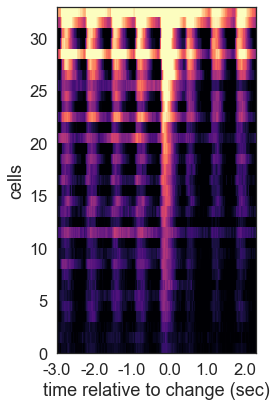

In [215]:


# create the plot
fig, ax = plt.subplots(figsize=(4,6))
ax.pcolormesh(response_matrix_sorted, cmap='magma', vmin=0, vmax=np.percentile(response_matrix, 95))
ax.set_ylabel('cells')

# set xticks and xticklabels
ax.set_xticks(np.arange(0, response_matrix.shape[1], 35))
ax.set_xticklabels(np.arange(timestamps[0], timestamps[-1]))
ax.set_xlabel('time relative to change (sec)');
fig.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.5: Compute a sparseness metric for one cell</b>

<p>lifetime sparseness is a metric for how selective and sparse a cell's activity is across conditions, bounded between 0 and 1. A high value of this metric indicates high selectivity - a differential response to one or a few stimulus conditions over others. A low value of this metric indicates a similar response across all conditions. 

<p> 1) Create an array containing the mean response across all flashes for each of the 8 images in the session for one cell. Hint: Use the <code>get_mean_df</code> function introduced in Exercise 2.4 to create a dataframe with the mean response by image for all cells, using the <code>flash_response_df</code>. 
    
<p> 2) Plot this array to visualize the cell's tuning for images. 
    
</div>

In [ ]:
fr = session.flash_response_df.copy()

In [ ]:
# get mean_df
mean_df = tools.get_mean_df(fr, conditions=['cell_specimen_id', 'image_name'])

In [ ]:
# get array of image responses for one cell
cell_data = mean_df[mean_df.cell_specimen_id==cell_specimen_id]
image_responses = cell_data.mean_response.values
images = cell_data.image_name.values
# plot it
plt.plot(image_responses, 'o')
plt.xticks(np.arange(0,len(images),1), labels=images, rotation=90);
plt.ylabel('mean dF/F')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> 2) Provide the image response array to the function below to compute the lifetime sparseness metric for your cell. How selective is this cell? 
    
</div>

In [ ]:
def compute_lifetime_sparseness(image_responses):
    # image responses should be an array of the trial averaged responses to each image
    # sparseness = 1-(sum of trial averaged responses to images / N)squared / (sum of (squared mean responses / n)) / (1-(1/N))
    # N = number of images
    # after Vinje & Gallant, 2000; Froudarakis et al., 2014
    N = float(len(image_responses))
    ls = ((1-(1/N) * ((np.power(image_responses.sum(axis=0),2)) / (np.power(image_responses,2).sum(axis=0)))) / (1-(1/N)))
    return ls

In [ ]:
# compute lifetime sparseness
ls = compute_lifetime_sparseness(image_responses)
print(ls)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Across Session Physiology Exercises</h2>
  
<p>This section deals with comparing neural activity across different experiment sessions, both at the single cell and population level. It also teaches you some neat pandas tricks for reformatting data in useful ways.  
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 3.1: Follow along to learn some useful pandas tricks for multi session data comparison</b>

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
One interesting aspect of this dataset is that there are multiple behavior + ophys sessions from each animal. In some cases we might want to perform analyses that compare multiple sessions from the same container to know how behavior or neural responses change with each stage of the task.     

</div>

In [ ]:
experiments = cache.experiment_table
experiments.head(15)[['container_id','stage_name','ophys_experiment_id']]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
From there, we can select two experiment dataframes we wish to analyze from the same container.
</div>

In [ ]:
#an active, image_set A dataset
a_trials = cache.get_session(792815735).trials
#an active, image_set B dataset
b_trials = cache.get_session(795953296).trials

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
We can compare many metrics between these two sessions, as an example, the hit rate between each session using code developed above
</div>

In [ ]:
fig, ax = plt.subplots(2,figsize=(10,4))

ax[0].plot(a_trials.change_time, a_trials.reward_rate)
ax[0].set_title('image set A session')
ax[0].set_ylabel ('reward rate')

ax[1].plot(b_trials.change_time, b_trials.reward_rate)
ax[1].set_xlabel ('time in session (sec)')
ax[1].set_title('image set B session')
ax[1].set_ylabel ('reward rate');
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
For more in-depth analysis and to ease plotting, we can merge the two dataframes, passing keys to keep their labels
</div>

In [ ]:
a_b = pd.concat([a_trials,b_trials], keys=['a', 'b'])
a_b.head()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Note that looking at the tail lets you see the b trial dataframe that was just merged
</div>

In [ ]:
a_b.tail()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
We can calculate simple metrics by grouping by the index. In a multi-index dataframe, these can be referenced by their level
</div>

In [ ]:
a_b.groupby(level=0).trial_length.mean()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
We can also quickly plot metrics across the two sessions
</div>

In [ ]:
ax = sns.boxplot(data=a_b[a_b.go].reset_index(),x='level_0', y='response_latency')
ax.set_xlabel('image set')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
We can also get an idea if there are different numbers of trials, in this instance hit trials
</div>

In [ ]:
sns.countplot(data=a_b.reset_index()[['level_0','hit']],x='hit',hue='level_0')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> <b>Exercise 3.2: Compare the activity of matched cells across sessions</b>
   
<p> In our experimental design, the same 2-photon field of view is imaged across multiple sessions. A cell may be observed in one or more sessions, dependending on whether or not it is active on different days. Cells that are identified across multiple days have the same 'cell_specimen_id' in all sessions in which they were observed. 
    
<p> To compare activity across multiple sessions, you can use another useful tool provided in the SDK utilities - the <code>create_multi_session_mean_df</code> function.      
    
<p> 1) Run help on  <code>create_multi_session_mean_df</code>. What are its inputs and outputs? 
    
<p> 2) Create a multi session df using the same 2 experiment sessions that were used above (<code>experiment_ids = [792815735, 795953296]</code>) and assign the output to variable called <code>multi_session_df</code>. Set <code>flashes = True</code> to merge across the <code>flash_response_df</code> for the 2 sessions. Note: If <code>flashes = False</code> (the default setting), the function will merge the <code>trial_response_df</code>. 
    
</div>

In [ ]:
help(tools.create_multi_session_mean_df)

In [ ]:
multi_session_df = tools.create_multi_session_mean_df(cache, [792815735,795953296], flashes=True, conditions=['cell_specimen_id','image_name'])

In [ ]:
multi_session_df.columns

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
By using the <code>groupby()</code> command you can quickly generate comparisons of the same cells across sessions. 
</div>

In [ ]:
# get the mean response across images for each experiment session, for each cell_specimen_id
multi_session_df.groupby(['cell_specimen_id','experiment_id'])['mean_response'].mean()

<iv style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Using the <code>unstack()</code> command you can regroup these values by cell
    
<p> How can you tell if a cell was identified in both sessions?
</div>

In [ ]:
# unstack the grouped dataframe to get each cell's mean_response for different experiments as columns
cell_exp_mean = multi_session_df.groupby(['cell_specimen_id','experiment_id'])['mean_response'].mean()
cell_exp_mean.unstack(level=-1).head()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
If the function you want to apply after the <code>groupby()</code> command operates on something other than a numeric value, such as the <code>mean_trace</code> array, you might need to use the <code>.apply(<function>)</code>command. 
    
</div>

In [ ]:
# get the mean trace across images for each experiment, for each cell
mean_trace = multi_session_df.groupby(['cell_specimen_id','experiment_id'])['mean_trace'].apply(np.mean)
mean_trace.head()

In [ ]:
# unstack to get experiments as columns
mean_trace = mean_trace.unstack(level=-1)
mean_trace.head()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
<p> 3) Use the <code>mean_trace</code> dataframe generated above to plot the dF/F trace for one cell across the 2 experiment sessions. Include the <code>experiment_id</code> that each trace came from in the figure legend. Make sure it is a cell that has a <code>mean_trace</code> in both sessions. 
    
<p> How does the response differ across days? 
    
</div>

In [ ]:
mean_trace.head()

In [ ]:
cell_data = mean_trace.iloc[0]
# hacky way to get timestamps for now
flash_timestamps = session.flash_response_df.iloc[0]['dff_trace_timestamps'] - session.flash_response_df.iloc[0]['start_time']
for experiment_id in cell_data.keys():
    plt.plot(flash_timestamps, cell_data[experiment_id], label=str(experiment_id))
plt.legend(loc='upper left');
plt.xlabel('time relative to stimulus onset (sec)');
plt.ylabel('dF/F');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> <b>Exercise 3.3: Merge all the experiments from a single container and plot the mean response for different image sets</b>   
    
<p> 1) Get all experiment_ids for a single container_id. 

<p> 2) Merge the trial_response_dfs across sessions using <code>create_multi_session_mean_df</code> and assign the output to 'container_trial_mean_df'. 
</div>

In [ ]:
# get experiment_ids for one container
experiment_ids = experiments[experiments.container_id == 803517529].ophys_experiment_id.values

In [ ]:
# create multi_session dataframe with experiments from this container
container_trial_mean_df = tools.create_multi_session_mean_df(cache, experiment_ids)

In [ ]:
# group by experiment_id and stage_name to get the mean response across different session types
container_trial_mean_df.groupby(['experiment_id','stage_name']).mean_response.mean()

In [ ]:
# group by experiment_id and image_set to get the mean response across different image sets
container_trial_mean_df.groupby(['experiment_id','image_set']).mean_response.mean()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">    
<p> 3) Plot the mean response for image set A vs. image set B for each cell as a scatter plot. Hint: use <code>groupby()</code> and <code>unstack()</code> as demonstrated above to make it more efficient. 
</div>

In [ ]:
# ineffient but intuitive way
fig, ax = plt.subplots()
for cell_specimen_id in container_trial_mean_df.cell_specimen_id.unique():
    df = container_trial_mean_df[container_trial_mean_df.cell_specimen_id==cell_specimen_id].copy()
    a_response = df[df.image_set=='A'].mean_response.mean()
    b_response = df[df.image_set=='B'].mean_response.mean()
    ax.plot(a_response, b_response, 'ok')
ax.plot([0,0.4],[0,0.4],'k--')
ax.set_xlabel('mean dF/F image set A');
ax.set_ylabel('mean dF/F image set B');

In [ ]:
# efficient pandas magic way
# plot the mean response of each cell to image set A vs image set B
cell_image = container_trial_mean_df.groupby(['cell_specimen_id','image_set']).mean_response.mean().unstack(level=1)
plt.plot(cell_image.values[:,0],cell_image.values[:,1],'ko')
plt.plot([0,0.25],[0,0.25],'k--');
plt.xlabel('mean dF/F image set A');
plt.ylabel('mean dF/F image set B');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">    
<p> 4) Plot the population average trace across cells for image set A vs. image set B using the values of the <code>mean_trace</code> column. Indicate the image set for each trace in a figure legend. 
<p> Bonus: plot the x-axis in seconds. 
<p> Which image set evokes stronger activity across the population? 
</div>

In [ ]:
# solution method 1
fig, ax = plt.subplots()
df = container_trial_mean_df.copy()
# get population average trace for both image sets
a_response = df[df.image_set=='A'].mean_trace.mean()
b_response = df[df.image_set=='B'].mean_trace.mean()
# get timestamps to plot
tr = session.trial_response_df.copy()
timestamps = tr.iloc[0].dff_trace_timestamps - tr.iloc[0].change_time
# plot both traces
ax.plot(timestamps, a_response, color='r', label='A')
ax.plot(timestamps, b_response, color='b', label='B')
plt.xlabel('time relative to change (sec)')
plt.ylabel('mean dF/F')
plt.legend();

In [ ]:
# solution method 2
# plot the average trace for all cells by image_set
image_set_trace= container_trial_mean_df.groupby('image_set').mean_trace.apply(np.mean)
tr = session.trial_response_df.copy()
timestamps = tr.iloc[0].dff_trace_timestamps - tr.iloc[0].change_time
plt.plot(timestamps, image_set_trace.loc['A'],'r',label='A')
plt.plot(timestamps, image_set_trace.loc['B'],'b',label='B')
plt.xlabel('time relative to change (sec)')
plt.ylabel('mean dF/F')
plt.legend();

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 3.4: Plot the trial averaged response for passive vs. active sessions from one container</b>
   
<p> Use the pandas skills learned above to plot the mean response on passive vs. active sessions. 
    
<p> 1) Plot the cell by cell mean response for passive vs. active as a scatterplot. Use the <code>passive</code> column of the <code>container_trial_mean_df</code> dataframe to differentiate passive vs. active.  
</div>

In [ ]:
# mean across the entire session
container_trial_mean_df.groupby('passive').mean_response.mean()

In [ ]:
# cell by cell plot
cell_passive = container_trial_mean_df.groupby(['cell_specimen_id','passive']).mean_response.mean().unstack(level=1)
plt.plot(cell_passive.values[:,0],cell_passive.values[:,1],'ko')
plt.plot([0,0.2],[0,0.2],'k--');
plt.xlabel('mean dF/F active sessions');
plt.ylabel('mean dF/F passive sessions');

In [ ]:
# plot the average trace across all cells by active/passive
passive = container_trial_mean_df.groupby('passive').mean_trace.apply(np.mean)
timestamps = tr.iloc[0].dff_trace_timestamps - tr.iloc[0].change_time
plt.plot(timestamps,passive.loc[False],'r',label='Active')
plt.plot(timestamps,passive.loc[True],'b',label='Passive')
plt.xlabel('time relative to change (sec)')
plt.ylabel('mean dF/F')
plt.legend()